## Example of the affect of defining misspecified prior densities on branch lengths

Amine Remita

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from nnTreeVB.data import evolve_seqs_full_homogeneity    
from nnTreeVB.data import build_tree_from_nwk
from nnTreeVB.data import simulate_tree
from nnTreeVB.data import build_msa_categorical
from nnTreeVB.data import TreeSeqCollection
#
from nnTreeVB.checks import check_sim_blengths
from nnTreeVB.checks import check_sim_simplex
#
from nnTreeVB.reports import plot_weights_grads_epochs
from nnTreeVB.reports import violinplot_from_dataframe
#
from nnTreeVB.models.vb_models import VB_nnTree
from nnTreeVB.models.evo_models import compute_log_likelihood

In [3]:
import time
import math
import random
import copy
from pprint import pprint
from collections import OrderedDict

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from scipy import stats

np.set_printoptions(precision=5)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', "r'All-NaN (slice|axis) encountered'")

In [5]:
verbose = True

device = torch.device("cpu")
# # device = torch.device("cuda")

In [6]:
# seed = 49685
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sequence alignment simulation

In [7]:
## Define a function to simulate complete dataset (sequence alignment + tree)
## Branch lengths will be sampled from an exponential distribution with a mean defined by the user
## We use JC69 model to simulate the evolution of the sequences

def simulate_jc69_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001):

    # Simulate branch lengts
    rate = 1 / blen_mean
    sim_blengths = check_sim_blengths("exponential({})".format(rate), nb_taxa)[0]

    print("Simulated brench lengths:")
    print("Number: {}".format(len(sim_blengths)))
    print("Mean: {}".format(np.mean(sim_blengths)))
    print("Variance: {}".format(np.var(sim_blengths)))
    print("Tree length: {}".format(np.sum(sim_blengths)))

    # Simulate tree
    tree_data = simulate_tree(nb_taxa, sim_blengths, seed)

    the_tree = tree_data[0]
    taxa = list(tree_data[1].keys())

    str_tree = the_tree.write(format=1) # get newick string
    the_tree.write(format=1, outfile=tree_file)
    
    # Sequence evolutionary parameters simulation
    # uniform distributed substitution rates
    sim_rates = check_sim_simplex("0.166", 6)[0]

    # uniform distributed relative frequencies
    sim_freqs = check_sim_simplex("0.25", 4)[0]
    sim_freqs[1], sim_freqs[2] = sim_freqs[2], sim_freqs[1] # order of nuc is different in pyvolve

    # Sequence simulation using pyvolve
    all_seqdict = evolve_seqs_full_homogeneity(
        str_tree,
        fasta_file=False,
        nb_sites=alignment_len,
        subst_rates=sim_rates,
        state_freqs=sim_freqs,
        return_anc=True,
        verbose=verbose)

    sequences = [all_seqdict[s] for s in taxa]
    seq_taxa = {s:all_seqdict[s] for s in taxa}
    
    # write fasta file
    records = [SeqRecord(Seq(seq_taxa[taxon]), taxon, '', '') for taxon in seq_taxa]
    SeqIO.write(records, fasta_file, "fasta")
    
    # Extract branch lengths from the tree
    true_branches = torch.zeros(len(the_tree.get_descendants()))
    # print(true_branches.shape[0])

    for node in the_tree.traverse("postorder"):

        if node.postrank < true_branches.shape[0]:
    #         print(node.name, node.rank, node.dist)
            true_branches[node.postrank] = node.dist

    true_branches = true_branches.unsqueeze(-1)
    print("\ntrue_branches")
    print(len(true_branches))
    print(true_branches.sum())

    # Build a treeSeq collection
    treeseqs = TreeSeqCollection(fasta_file, tree_file)
    tree_obj = treeseqs.tree
    logl_tree = copy.deepcopy(tree_obj)
    
    # Compress the alignment to get the site patterns
    motifs_cats = build_msa_categorical(treeseqs, nuc_cat=False)
    x = torch.from_numpy(motifs_cats.data)
    x, x_counts = x.unique(dim=0, return_counts=True)

    # Compute log-likelihood
    tm_args = {"b":true_branches.unsqueeze(0).squeeze(2)}
    freqs = torch.ones(4)/4

    with torch.no_grad():
        true_lls = (compute_log_likelihood(
            logl_tree,
            x,
            "jc69",
            tm_args,
            freqs,
            rescaled_algo=True) * x_counts).sum()

    print("Log likelihood {}".format(true_lls))

    return true_branches, tree_obj, x, x_counts

In [9]:
## Test function
fasta_file = 'sim.fasta'
tree_file = 'sim.nw'

blens, obj_tree, X, X_counts = simulate_jc69_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001)

Simulated brench lengths:
Number: 61
Mean: 0.0008526261552825608
Variance: 1.2449080591739317e-06
Tree length: 0.05201019547223621
Evolving sequences with the amazing Pyvolve

true_branches
61
tensor(0.0520)
Log likelihood -1882.594482421875


## Fitting and sampling nnTreeVB models

In [37]:
def fit_sample_vb_jc69_model(
    # init and fit hyperparams
    tree_obj,
    x,
    x_counts,
    #
    b_prior_dist="exponential",
    b_prior_params=[10.],
    b_learn_prior=False,
    #
    elbo_type="elbo",
    grad_samples=torch.Size([1]),
    alpha_kl=1.,
    max_iter=1000,
    optimizer="adam",
    learning_rate=0.1,
    weight_decay=0.0,
    scheduler_lambda=lambda epoch: 1.0,
    save_fit_history=False,
    save_grad_stats=False,
    save_weight_stats=False,
    verbose=2,

    # sampling hyperparams
    nb_samples = torch.Size([1000])
):
    print("\tInitialize the model")
    
    model = VB_nnTree(
        copy.deepcopy(tree_obj),
        subs_model="jc69",
        ## branch length prior
        b_prior_dist=b_prior_dist,
        b_prior_params=b_prior_params,
        b_learn_prior=b_learn_prior,
        ## branch length variational
        b_var_dist="normal",
        b_var_params=[0.1, 0.1],
        b_var_transform=torch.distributions.ExpTransform(),
        ##
        device="cpu"
    )
    
    print("\tFit the model")

    model.fit(
        x, 
        x_counts,
        elbo_type=elbo_type,
        grad_samples=grad_samples,
        alpha_kl=alpha_kl,
        max_iter=max_iter,
        optimizer=optimizer,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        scheduler_lambda=scheduler_lambda,
        save_fit_history=save_fit_history,
        save_grad_stats=save_grad_stats,
        save_weight_stats=save_weight_stats,
        verbose=verbose
    )
    
    print("\tSample from the model")
    
    samples = model.sample(
        x, 
        x_counts,
        elbo_type=elbo_type,
        alpha_kl=alpha_kl,
        nb_samples=nb_samples
    )
    
    return model, samples

In [11]:
## Test function
model, samples = fit_sample_vb_jc69_model(obj_tree, X, X_counts)

Initialize the model
Fit the model
0m 0s	Epoch: 10	ELBO: -26514.857	LogL: -26276.906	LogP: -136.999	LogQ: 100.952	KL: 237.951
0m 0s	Epoch: 20	ELBO: -11824.472	LogL: -11694.390	LogP: 35.619	LogQ: 165.700	KL: 130.082
0m 0s	Epoch: 30	ELBO: -6549.374	LogL: -6416.412	LogP: 91.548	LogQ: 224.510	KL: 132.963
0m 0s	Epoch: 40	ELBO: -4598.688	LogL: -4460.218	LogP: 111.918	LogQ: 250.389	KL: 138.471
0m 0s	Epoch: 50	ELBO: -3795.634	LogL: -3638.077	LogP: 120.455	LogQ: 278.012	KL: 157.557
0m 0s	Epoch: 60	ELBO: -3368.721	LogL: -3214.218	LogP: 124.873	LogQ: 279.376	KL: 154.503
0m 0s	Epoch: 70	ELBO: -3124.042	LogL: -2963.875	LogP: 127.485	LogQ: 287.652	KL: 160.167
0m 0s	Epoch: 80	ELBO: -2937.297	LogL: -2759.968	LogP: 129.659	LogQ: 306.988	KL: 177.329
0m 1s	Epoch: 90	ELBO: -2820.698	LogL: -2649.013	LogP: 130.857	LogQ: 302.542	KL: 171.685
0m 1s	Epoch: 100	ELBO: -2759.169	LogL: -2578.277	LogP: 131.623	LogQ: 312.515	KL: 180.892
0m 1s	Epoch: 110	ELBO: -2680.677	LogL: -2503.590	LogP: 132.416	LogQ: 309.504	KL: 

0m 11s	Epoch: 940	ELBO: -2106.690	LogL: -1909.318	LogP: 139.196	LogQ: 336.568	KL: 197.372
0m 11s	Epoch: 950	ELBO: -2115.282	LogL: -1919.546	LogP: 139.179	LogQ: 334.915	KL: 195.737
0m 11s	Epoch: 960	ELBO: -2111.099	LogL: -1911.484	LogP: 139.110	LogQ: 338.725	KL: 199.614
0m 11s	Epoch: 970	ELBO: -2112.819	LogL: -1900.544	LogP: 139.349	LogQ: 351.624	KL: 212.275
0m 11s	Epoch: 980	ELBO: -2107.829	LogL: -1908.854	LogP: 139.298	LogQ: 338.274	KL: 198.976
0m 11s	Epoch: 990	ELBO: -2108.321	LogL: -1908.147	LogP: 139.275	LogQ: 339.449	KL: 200.174
0m 11s	Epoch: 1000	ELBO: -2107.131	LogL: -1904.050	LogP: 139.254	LogQ: 342.335	KL: 203.082

Optimization rate 1.0
Sample from the model


In [12]:
print(samples["logl"])
print(samples["b"].mean(0).sum())

-1912.2811
0.12924062


## Comparison 1. Branch lengths estimation

In [138]:
# Hyperparams of prior densities

prior_hyperparams = [["exponential", 0.1, False, "FPD(0.1)", "tomato"],
                     ["exponential", 0.01, False, "FPD(0.01)", "tomato"],
                     ["exponential", 0.001, False, "FPD(0.001)", "tomato"],
                     ["exponential", "uniform", True, "LPD", "turquoise"],
                     ["exponential_nn", "uniform", True, "NPD", "lightseagreen"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

### 1. Simulate a dataset

In [116]:
exp_mean_blens = 0.1
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 32

In [117]:
# Generate a dataset
fasta_file = 'sim_blens_{}_l{}_t{}.fasta'.format(str_exp_mean, aln_size, taxa_size)
tree_file = 'sim_blens_{}_l{}_t{}.nw'.format(str_exp_mean, aln_size, taxa_size)

blens, obj_tree, X, X_counts = simulate_jc69_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=aln_size,
    nb_taxa=taxa_size,
    blen_mean=exp_mean_blens)

Simulated brench lengths:
Number: 61
Mean: 0.0967310263662419
Variance: 0.009188692075019472
Tree length: 5.900592608340756
Evolving sequences with the amazing Pyvolve

true_branches
61
tensor(5.9006)
Log likelihood -21789.7734375


### 2. Fit and sample VB models w/ different prior densities

In [118]:
# Fit and sample multiple VB models with different prior densities
blen_samples = []
for i in range(len(prior_hyperparams)):
    print("\nVB model {}".format(prior_hyperparams[i][3]))

    model, samples = fit_sample_vb_jc69_model(obj_tree, X, X_counts, 
                                              b_prior_dist=prior_hyperparams[i][0],
                                              b_prior_params=prior_hyperparams[i][1],
                                              b_learn_prior=prior_hyperparams[i][2],
                                              verbose=1)
    
    blen_samples.append(samples["b"])


VB model FPD(0.1)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.01)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.001)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. Mean of branch lenghts comparison

In [119]:
blens_mean = np.array([s.mean(1) for s in blen_samples])
blens_mean.shape

(5, 1000)

In [120]:
blens_mean = np.vstack(blens_mean).T
blens_mean.shape

(1000, 5)

In [121]:
df_bl_mean = pd.DataFrame(data=blens_mean, columns=model_names)
df_bl_mean.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.098813,0.097688,0.097723,0.098858,0.096852
std,0.001559,0.001487,0.001458,0.001694,0.001390
min,0.094031,0.092891,0.092608,0.094471,0.091726
25%,0.097763,0.096729,0.096731,0.097715,0.095916
50%,0.098808,0.097635,0.097751,0.098819,0.096833
75%,0.099787,0.098697,0.098680,0.100020,0.097781
max,0.104351,0.102438,0.102889,0.106235,0.101699


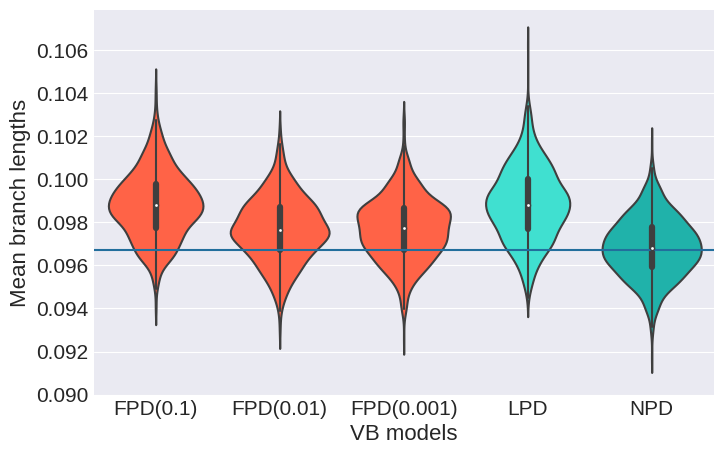

In [155]:
true_blen_mean = blens.mean().item() # horizontal line
violinplot_from_dataframe(df_bl_mean, 
                          line=true_blen_mean, 
                          y_limit=[0.09, None], 
                          xlabel="VB models", 
                          ylabel="Mean branch lengths",
                          palette=model_colors,
                          xticks_rotation=0
                         )

### 4. Total tree length comparison

In [123]:
tree_lens = np.array([s.sum(1) for s in blen_samples])
tree_lens.shape

(5, 1000)

In [124]:
tree_lens = np.vstack(tree_lens).T
tree_lens.shape

(1000, 5)

In [125]:
df_tl = pd.DataFrame(data=tree_lens, columns=model_names)
df_tl.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.027622,5.958987,5.961129,6.030353,5.907985
std,0.095082,0.090690,0.088957,0.103324,0.084790
min,5.735914,5.666352,5.649107,5.762721,5.595316
25%,5.963553,5.900461,5.900616,5.960612,5.850867
50%,6.027309,5.955729,5.962811,6.027935,5.906835
75%,6.087031,6.020503,6.019478,6.101239,5.964631
max,6.365421,6.248727,6.276254,6.480310,6.203651


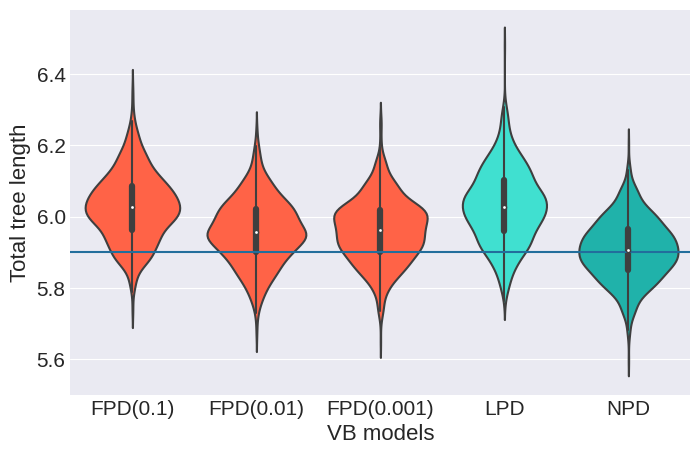

In [151]:
# import seaborn as sns
true_tree_len = blens.sum().item() # horizontal line
violinplot_from_dataframe(df_tl, 
                          line=true_tree_len, 
                          y_limit=[5.5, None],
                          xlabel="VB models", 
                          ylabel="Total tree length",
                          palette=model_colors,
                          xticks_rotation=0
                         )

## Comparison 2.